# Introduction to Fourier Theory and iPython Notebooks

Renee Hlozek and Jeff McMahon

We will take a look at what Fourier transforms do in 1D and 2D.  In its simplest form, a 1D Fourier transform takes a time-varying function, measures possible cycles it contains, and returns the amplitude, offset and rotation for all cycles that were found.

An iPython Notebook consists of a standard and efficient Python back end with a web-based interface.  The interface includs both text boxes and code boxes.  The text boxes support latex math and the output of the code (both text and plots) are all stored in the document.  All cells in a given notebook share the same namespace.  This arrangement allows for increadibly well documnted code that is easy to read and support.

To get started with this intro, we must first import a number of python libraries.

In [106]:
import matplotlib   # plotting libraries  
import matplotlib.pyplot as plt   # plotting libraries  
#import cmath as cm  # complex math  ### JR: this isn't needed, just use np
#import pylab as pl  # plotting and numerical routines ### JR: this isn't needed, just use plt
import numpy as np  # numerical routines 
import matplotlib.cm as cmap  ## color map for 2d plotting
import time

pi2 = np.pi * 2.0   # a useful constatn: 2 * pi
# the next line is an "magic word" that puts the plots into the notebook rather than external
%matplotlib inline 
plt.rcParams.update({'font.size': 14})  # Sets font size used in figures
plt.rcParams['figure.figsize'] = [12,10] # Sets figure sizes, change this before each plot to customize.


We start by writing our own 
<a href="https://en.wikipedia.org/wiki/Discrete_Fourier_transform">discrete Fourier transform
</a>

$$X_k = \sum_{n=0}^{N-1} x_n e^{-2\pi i k n / N}$$

and its inverse transform

$$x_n = \frac 1 N \sum_{n=0}^{N-1} X_k e^{2\pi i k n / N}$$

Note that both $X_k$ and $x_n$ are (generally) complex.  We often deal with real $x_n$ (like in a voltage as a function of time), in which case the $X_k$ are still complex.

With every Fourier transform routine, make sure to check the normalisation and sign conventions.  In numpy, the normalizations shown above are known as the "backward" normalization, which is the default.  The "forward" normalization puts the factor of $1/N$ in front of the first equation, and the "ortho" normalization makes the equations symmetric by putting a $1/\sqrt{N}$ in front of each equation.

These three FFT normalizations are readily available via the "norm" argument in numpy:

    x_fft = np.fft.fft(x,norm='backward')  # the default
    x_fft = np.fft.fft(x,norm='forward')   # 
    x_fft = np.fft.fft(x,norm='ortho')     #

Let's write our own FFT routines to verify that we understand numpy's implementation.

In [52]:
def fourier(x):
    '''  "backward" FFT normalization.
    '''
    N = len(x)
    fourier = np.zeros(N,dtype=complex)
    for k in range(N):
        fouriern=0
        for n in range(N):
            fouriern += x[n]*np.exp(-1j*pi2*k*n/N)
        fourier[k]=fouriern
    return fourier


def inv_fourier(X):
    '''  "backward" iFFT normalization.
    '''
    N = len(X)
    inv_fourier = np.zeros(N, dtype=complex)
    for n in range(N):
        inv_fourierk=0
        for k in range(N):
            inv_fourierk += X[k]*np.exp(1j*pi2*n*k/N)
        inv_fourier[n] = inv_fourierk/N
    return inv_fourier

 We want to test our code by inserting a sine wave signal and then checking that:

    (1) our Fourier transform matches the fft transform from within numpy
    (2) that if we inverse transform the Fourier transform we get the original wave back!

First we create an input sine wave signal.  You may have heard that (fancy) fft's are fastest if you do them on arrays that are powers of 2 in length;  that's true, but most round-number lengths are really fast as well.  So, 
for convenience you might consider using round powers of 10, unless you're very stressed for speed.

For example, we'll use N=1000 below, rather than $N=2^{10} = 1024$.

Input Sine Wave Paramaters:
frequency = 25.0
Amplitude = 50
Phase ang = 0.0


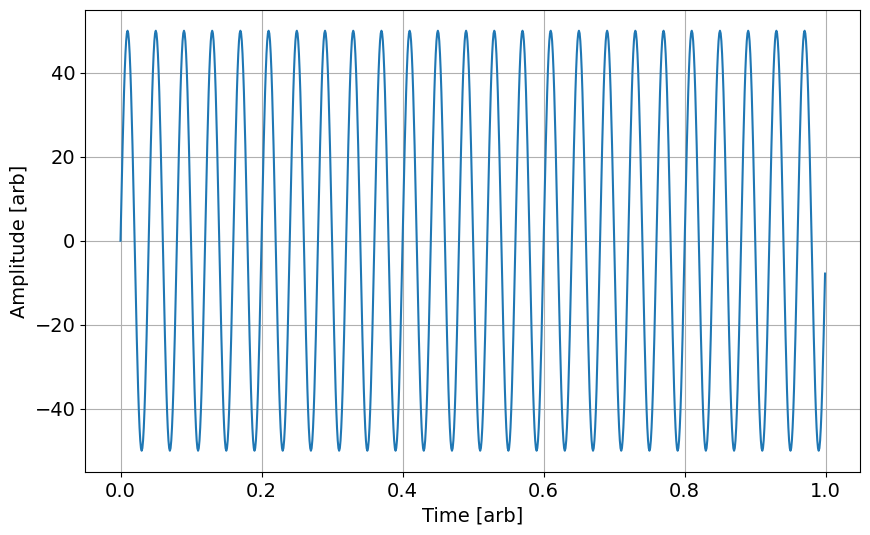

In [53]:
plt.rcParams['figure.figsize'] = [10,6]

N = 1000 # degrees (Number of samples)
a = 50   # Amplitude of the wave.
f = 25.  # frequency.
p = 0.   # phase angle, between 0 and 360 (degrees)

## print out the sine wave paramaters 
print("Input Sine Wave Paramaters:")
print("frequency = " + str(f))   ## not that strings can be added in python, very convenient
print("Amplitude = " + str(a))
print("Phase ang = " + str(p))

## make a pure sine wave array
#t = np.arange(0,N)/N       # goes from zero to (N-1)/N 
t = np.linspace(0,1-1/N,N)  # Same.

fn = a * np.sin(pi2* f * t + p / 360. * pi2)   ## the pure sine wave 
fn_real = np.real(fn)
plt.plot(t,fn_real)
plt.xlabel("Time [arb]")
plt.ylabel("Amplitude [arb]")
plt.grid()


Next we calculate the Fourier transform using our fourier transform funciton and examine the results.    

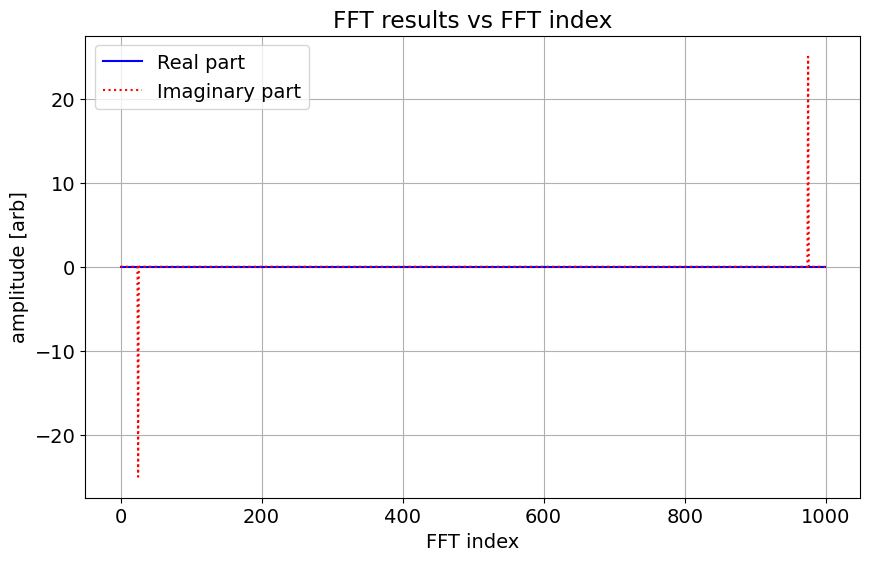

In [58]:
#fouriertrans = fourier(fn)  ## inverse FFT using our code
fouriertrans = (1/N)*fourier(fn)  # the "forward" normalization

plt.figure(figsize=(10, 6))  ## this resizes the figure to make it fit the screen
plt.xlabel("FFT index")
plt.ylabel("amplitude [arb]")
plt.title("FFT results vs FFT index")
plt.plot((fouriertrans.real),'b', label='Real part')
plt.plot((fouriertrans.imag),'r:', label='Imaginary part')
plt.legend()
plt.grid()

### Things to note: 

1. The output of the FFT includes both positive and negative frequency components (right and left going waves) as the algorithm cannot distinguish these two cases.  

2. If you set the phase angle to zero, you should get a purely imaginary (sine) result.  If you set it to 90 degrees, you should get a totally real (cosine) result.
    
2. The amplitude of the waves at a given frequency looks really messed up, way too large.  This is because of the normalization we chose.  The "forward" normalization gives something much more sensible; try changing to that and see what happens.  When you use the "forward" normalization, the amplitude at a given frequency is given by first finding the quadrature sum of the real and imaginary parts (e.g., the magnitude of the complex FFT), then adding the negative and positive frequency components.  

3. The x axis shown above is "array index";  we need to figure out how to convert that to frequency.  We'll do that next.  

### Making a frequency axis
    
As mentioned above, the FFT has elements representing positive and negative frequenecies.  
The notion of negative frequencies may seem a bit weird, 
but the sign of the frequency is related to the direction of the wave's travel, 
which you can see by looking at a typical wave equation

$$  f(x,t) = e^{i(k x - 2\pi f t)} \equiv e^{i\theta} . $$ 

If you want to "ride the wave" (ie stay on the crest) you need to move in $x$ as time increases such that $\theta$ stays constant.  Thus, if $k>0$, positive values of $f$ are associated with waves traveling in the positive $x$
direction, and negative values of $f$ are associated with waves taveling in the negative $x$ direction.  We 
are working with an array that represents a "snapshot" in that it is a function of only $t$, or only $x$, so we
can't tell what direction the wave is traveling, so our output array is agnostic about that.


By convention, the output FFT array is ordered such that zero frequency occurs array index zero.  It then counts up in frequency right going waves on the left counting up to the max frequnecy in the array, then left going waves counting down to the first non-zero frequency on the right.

Next we create an a frequency array in the same indexing scheme of the FFT.  We do this by identifiying the highest frequnecy that can be encoded within our array (See the Nyqyist-Shannon sampling theorem).  This is called the Nyquist frequency and is calculated as $f_{Nyquist} = (1/\Delta t_{sample})/2$, where $\Delta t_{sample}$ is the time between samples.

We can also create this frequency array using

    np.fft.fftfreq(N, d=delta_t). # delta_t = time between samples

Nyquist frequency:  500.0
Minimum frequencies: -500.0 -500.0
Maximum frequencies: 500.0 499.0


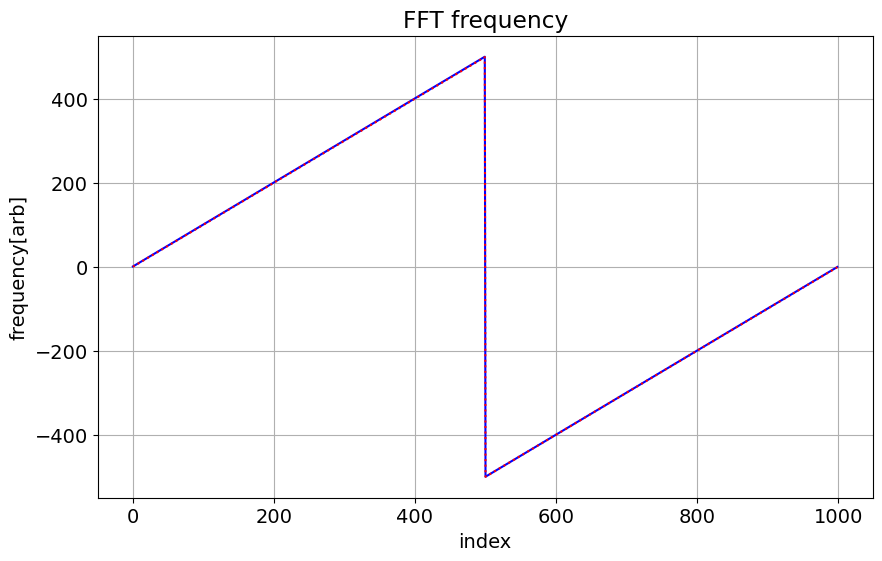

In [59]:
## First, make the frequency array by hand.  
# This is not quite right because you shouldn't have both a positve and negative bin at
# the Nyquist frequency;  by convention, you only get the negative one.
delta_t = (t[1]-t[0])  ## the step size for the t grid
freq_nyquist = 1/delta_t/2.
print("Nyquist frequency: ", freq_nyquist)

freq1 = np.roll(np.linspace(-1,1,N)*freq_nyquist,int(N/2))
freq2 = np.fft.fftfreq(N,delta_t)

## plot the freuency array
#plt.figure(figsize=(10, 6))  ## this resizes the figure to make it fit the screen
plt.xlabel("index")
plt.ylabel("frequency[arb]")
plt.title("FFT frequency")
plt.plot(freq1,'b', label='freq1')
plt.plot(freq2,'r:', label='freq2')
plt.plot()
plt.grid()

print('Minimum frequencies:',np.min(freq1),np.min(freq2))
print('Maximum frequencies:',np.max(freq1),np.max(freq2))


So, the two frequency arrays are pretty close to the same, but the hand-built one is a bit off.  We'll use the one from fft.fftfreq from now on.

As expected the zero frequency is on the left and the maximum frequency (positive near-Nyquist) is in the middle.  The sign of the frequency encodes right vs left going waves.

Now that we have the frequency array we can plot the FFT vs frequency and easily interpret the results.

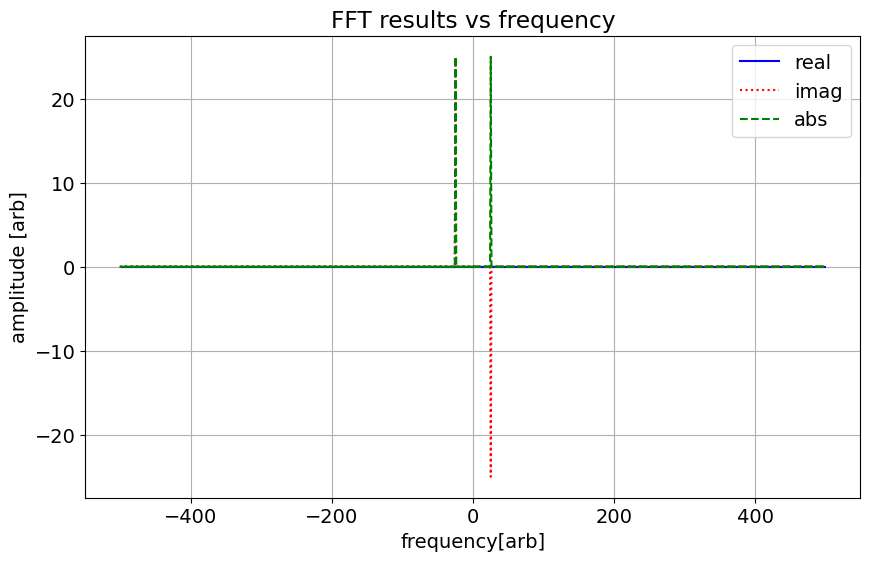

In [60]:
## make a plot of the real and imaginary parts of the FFT
plt.figure(figsize=(10, 6))  ## this resizes the figure to make it fit the screen
plt.xlabel("frequency[arb]")
plt.ylabel("amplitude [arb]")
plt.title("FFT results vs frequency")
plt.plot(freq2,(fouriertrans.real),'b',label='real')
plt.plot(freq2,(fouriertrans.imag),'r:', label='imag')
plt.plot(freq2,np.abs(fouriertrans),'g--', label='abs')
leg = plt.legend(loc='best')
#plt.axis([-100,100,-50,50])
plt.grid()

<font color='red'>EXERCISE: </font> 

1. Convince yourself that the FFT is giving the "correct" amplitude, by playing with the signal amplitude and doubling the peak heights shown to account for positive and negative frequencies.
2. Convince yourself that the frequency result is correct by changing the frequency of the input signal.
3. Play with the phase and change the signal back and forth from real to imaginary components.


Next we verify that the FFT and iFFT are in fact inverse functions:

maximum difference between the results: 3.563995834829186e-11 <- this should be zero within rounding error.


<Figure size 1000x600 with 0 Axes>

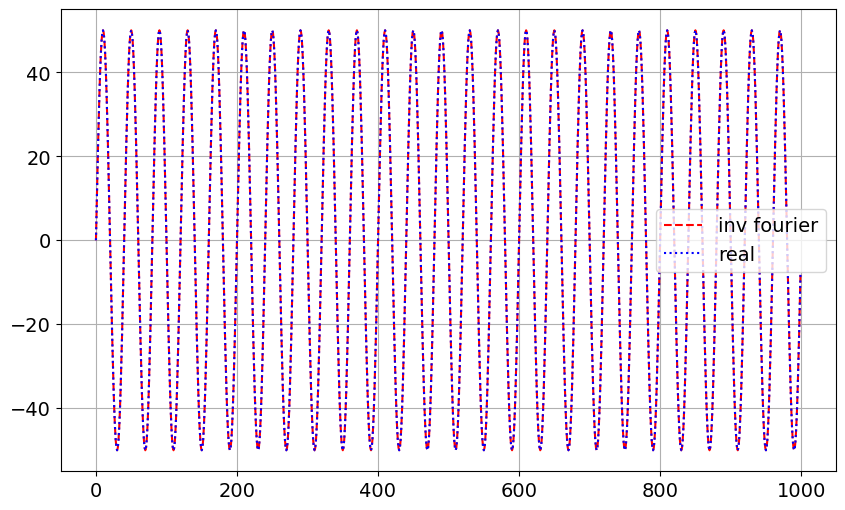

In [64]:
# If you used the "forward" normalization you have to convert back to the "backward" one before the ifft.
invfouriertrans = inv_fourier(N*fouriertrans)

plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(invfouriertrans, 'r--', label='inv fourier')
plt.plot(fn.real, 'b:', label='real')
plt.legend(loc='best')
plt.grid()
print("maximum difference between the results:", np.max(np.abs(invfouriertrans - fn)),"<- this should be zero within rounding error.")

In the final 1-d excercise we check that the Numpy implemntation of the FFT is identical to our implemntation

maximum difference between the results: 2.12888899430075e-12 <- this should be zero within rounding error.


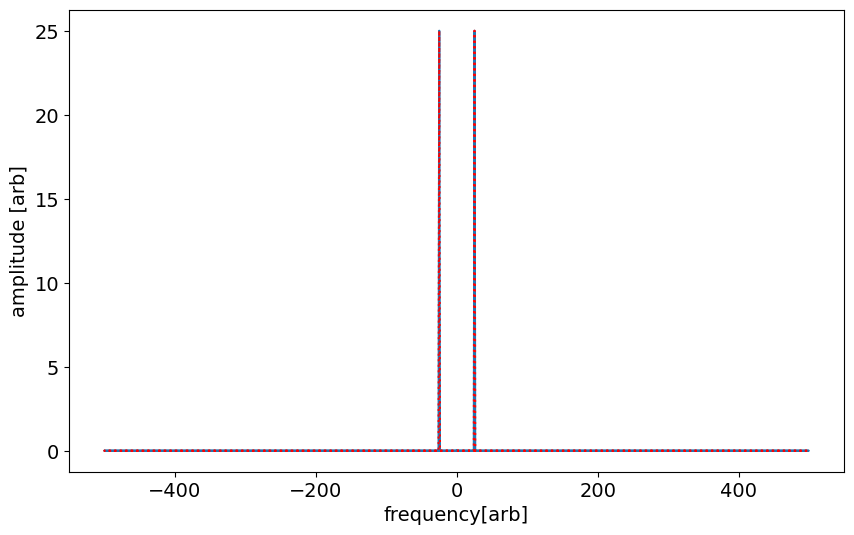

In [67]:
ftpl = np.fft.fft(fn,norm='forward')       ## FFT using numpy code

## make a plot comparing these functions
plt.xlabel("frequency[arb]")
plt.ylabel("amplitude [arb]")
plt.plot(freq2,np.abs(ftpl))
plt.plot(freq2,np.abs(fouriertrans),'r:')
#plt.show()
## calculate the maximum difference
print("maximum difference between the results:", np.max(np.abs(fouriertrans - ftpl)),"<- this should be zero within rounding error.")

Unsurprisingly the two algorythems agree within numerical rounding errors.

<font color='red'>EXCERCISE: </font> Write code to generate a few functions where we know the Fourier transform well, eg. a Gaussian, a delta function etc. Use the code above and plot the FTs of these functions. Use the numpy code to check!

(-20.0, 20.0)

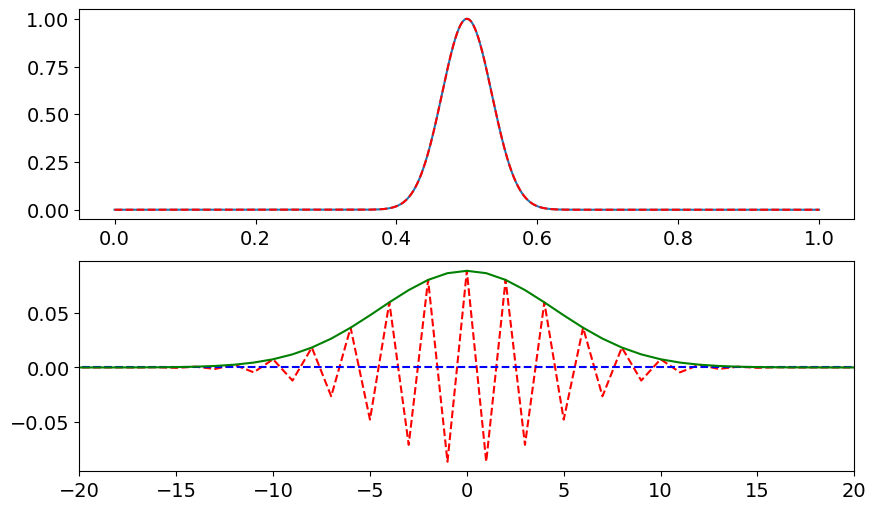

In [80]:
# Your code here.  Let's do this with numpy routines.

Npts = 5000
t = np.linspace(0,1-1/Npts,Npts)   # don't go all the way to one, so it's periodic!
dt = t[1]-t[0]
t0 = 0.5        # Center the gaussian here.  Play with this!
sigma = 0.05    # Width.  Play with this!
gauss = np.exp(-1*(t-t0)**2/sigma**2)    

freq = np.fft.fftshift(np.fft.fftfreq(Npts,dt))    # A nice, shifted frequency axis that goes from -fny to almost +fny
ft = np.fft.fft(gauss,norm='forward')  # We'll use this to make nice amplitudes
ft_shifted = np.fft.fftshift(ft)       # For plotting against freq, which is shifted
ift = np.fft.ifft(ft,norm='forward')

# plot the original, and ift(ft(gauss)) to show they agree
plt.subplot(2,1,1)
plt.plot(t,gauss)
plt.plot(t,ift,'r--')

# Plot the real, imaginary, and abs of the fft, to see behavior.
plt.subplot(2,1,2)
plt.plot(freq,np.real(ft_shifted),'r--')
plt.plot(freq,np.imag(ft_shifted),'b--')
plt.plot(freq,np.abs(ft_shifted),'g')
plt.xlim(-20,20)

# Normalization for noise
Use parseval's theorem to normalize the FFT...

(coming)


# Convolutions

The <a href="https://en.wikipedia.org/wiki/Convolution">convolution</a> of two discretely sampled (with $N$ samples) functions $f_i$ and $g_i$ is defined as 

$$(f * g)_n = \sum_{m=0}^{N-1} f_m g_{n-m}$$.

We're being a bit loose with notation and labels here; this is really the "circular discrete convolution" discussed on the wikipedia page linked above, when both functions are limited to the interval [0,N-1].  By $g(n-m)$ we also mean the "cyclic" version of that, where we roll around the array ends.

In other words, to calcuate this convolution: 
1. multiply two functions and sum them to get a number, then
2. repeat the procedure for all possible offsets.

In the following example we compute the convolution of a gaussian with a delta function.  Imagine here that the delta function is some "source in the data", and the gaussian represents our instrument response to that source,
smearing it out.

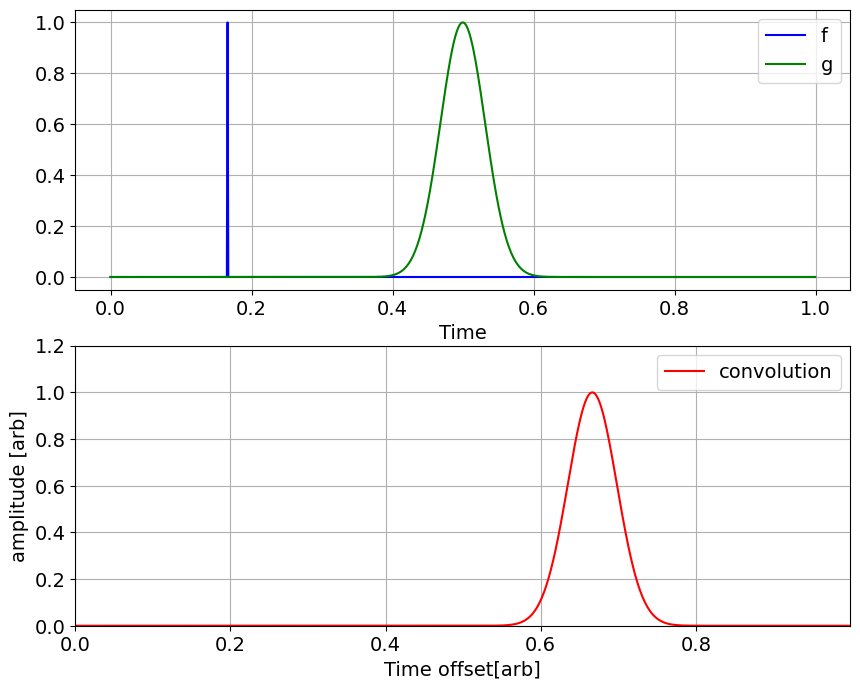

In [92]:

from scipy.stats import chi2
import numpy as np
Npts=1000
t = np.linspace(0,1-1/Npts,Npts)

# Make f == a single delta functions
f = np.zeros(N)
f[int(N/6)] = 1.
#f[int(N*5/6)] = 1.


gauss=True
if chi2:
    g = chi2.pdf(np.real(t), 55)
    g = g/np.max(g)
if gauss:
    g = np.exp(-5 * ((t-np.mean(t))/.1)**2.)

    
def convolution(f,g):   # Cyclic discrete convolution, rolling around array ends.
    g=g[::-1]
    N = np.size(f)
    conv = np.zeros(N)
    
    i = 0
    while (i <N):
        conv[i] = np.sum(f *np.roll(g,i))
        i+=1
    return(conv)

conv = convolution(f,g)


plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(t,f,'b', label='f')
plt.plot(t,g,'g', label='g')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(t,conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])
plt.xlabel("Time offset[arb]")
plt.ylabel("amplitude [arb]")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.grid()

If you selected "gaussian" to be true, note that since the green Gaussian curve is at the center of the numerical array, the convolution peaks at points when the offsets center the Gaussian on the blue delta functions (which requires rolling the Gaussian around the right side, in our case).  

For our applicaitons, such as the "instrument response to delta function signal" mentioned above, we often want to center the results such that the convolution peaks directly on the delta functions.  To do this we must center the convolving kernal (again Gaussian or $\chi^2$ depending on what you chose above) at zero time.  We do this in the following example by creating the Gaussian at the center of the array, then rolling it to be centered at the edges.

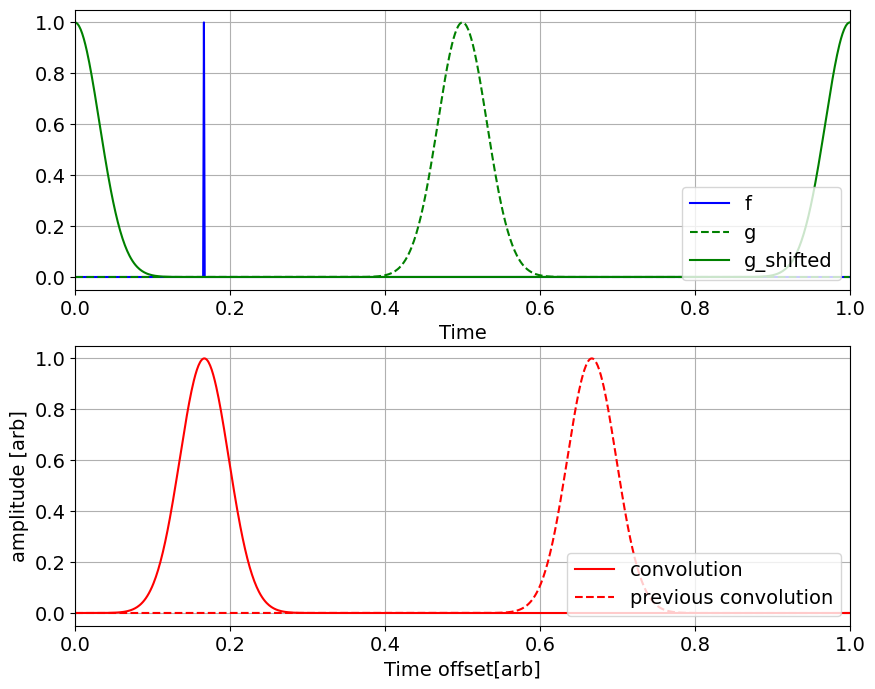

In [101]:
conv_prev = convolution(f,g)
# Roll the function g by the Nyquist frequency to shift it

g_shifted = np.roll(g,int(N/2))
conv = convolution(f,g_shifted)
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(t,f,'b', label='f')
plt.plot(t,g,'g--', label='g')
plt.plot(t,g_shifted,'g',label='g_shifted')
plt.xlabel('Time')
plt.xlim(0,1)
plt.legend(loc='lower right')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t,conv,"r", label='convolution')
plt.plot(t,conv_prev,"r--", label='previous convolution')
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.xlabel("Time offset[arb]")
plt.ylabel("amplitude [arb]")
plt.grid()


#plt.plot(t,f, label='f')
#plt.plot(t,g, label='g')
#plt.plot(t,conv_prev,"r", label='convolution')
#plt.plot(t,conv,"m", label='convolution shifted')
#plt.legend(loc='best')
#plt.axis([np.min(t),np.max(t),0,1.2])
#
#plt.xlabel("frequency[arb]")
#plt.ylabel("amplitude [arb]")
#plt.title("f (blue), g(green), and the convoliution of these (red)")
#plt.grid()

## fftshift is great
This "rolling by half the array length" that we did to $g$ turns out to be the same thing that is done by "fftshift".  We've been talking about the time-domain above, and I certainly think of "fftshift" as being a freqeuency domain thing, but it's just an array operation.  So, we can use it, and it turns out it will work with two (or more) dimensional arrays as well the 1D example we're working with here.


## Convolving using fft's
Speed is a big issue in convolutions.  Conveniently there is a way to massively accelerate this algorithm using the FFT with the convolution theorem:

$$(f * g) = iFFT(FFT(f) * FFT(g)). $$

In other words the convolution is the inverse fourier transform of the product of the fourier transforms of the two functions.

Let's show that this gives the same result as our "real-space convolution".

Real space convolution: 0.020183 seconds
Fourier space convolution: 6.638159 seconds


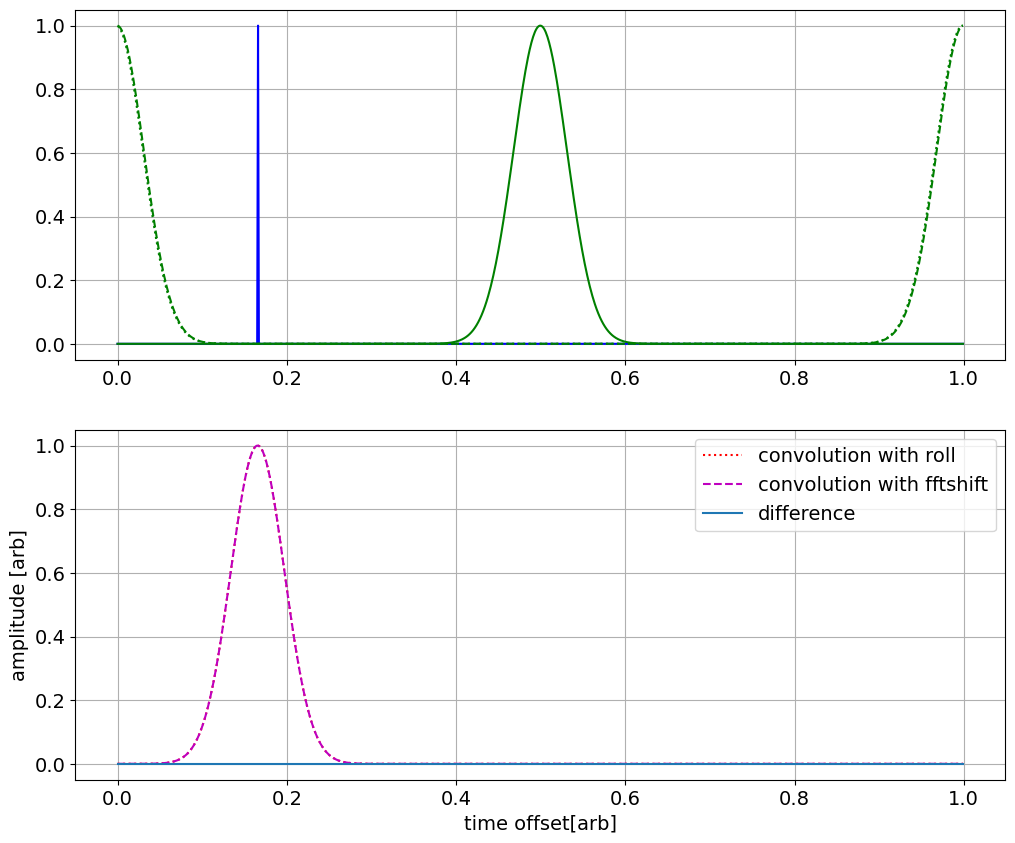

In [114]:
def fft_convolve(f,g):
    FFTf = fourier(f)
    FFTg = fourier(g)
    conv = inv_fourier(FFTf*FFTg)
    return conv

# We'll plot these below and show they're the same!
# g_rolled =  np.roll(g,int(N/2)-1)   # same as fftshift
g_rolled =  np.roll(g,int(N/2))
g_shifted = np.fft.fftshift(g)

# And these too!
tic1 = time.perf_counter()
#conv =   fft_convolve(f,g_rolled)   
conv = convolution(f,g_rolled)  # The "real space" way
tic2 = time.perf_counter()
npconv = fft_convolve(f,g_shifted)  # The "fourier" way
tic3 = time.perf_counter()
print("Real space convolution: {0:4f} seconds".format(tic2-tic1))
print("Fourier space convolution: {0:4f} seconds".format(tic3-tic2))

plt.subplot(2,1,1)
plt.plot(t,f, 'b',label='f')
plt.plot(t,g, 'g',label='g')
plt.plot(t,g_rolled, 'g:', label='g_rolled')
plt.plot(t,g_shifted,'g--', label='g_shifted')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t,conv,':r', label="convolution with roll")
plt.plot(t,npconv,'--m', label="convolution with fftshift")
plt.plot(t,conv-npconv, label='difference')
plt.legend(loc='best')
plt.xlabel("time offset[arb]")
plt.ylabel("amplitude [arb]")
plt.grid()

as expected the results are the same for this method as for the direct method

## Centering and FFTs

Centering of the input to the FFT is realted to the phase in the output.  In the following example (which is a cautionary tale) we see how offsetting the input can result in a strong phase modultion (eg rotation beteen real and imaginary) in the ouput.

(0.45, 0.55, -100.0, 100.0)

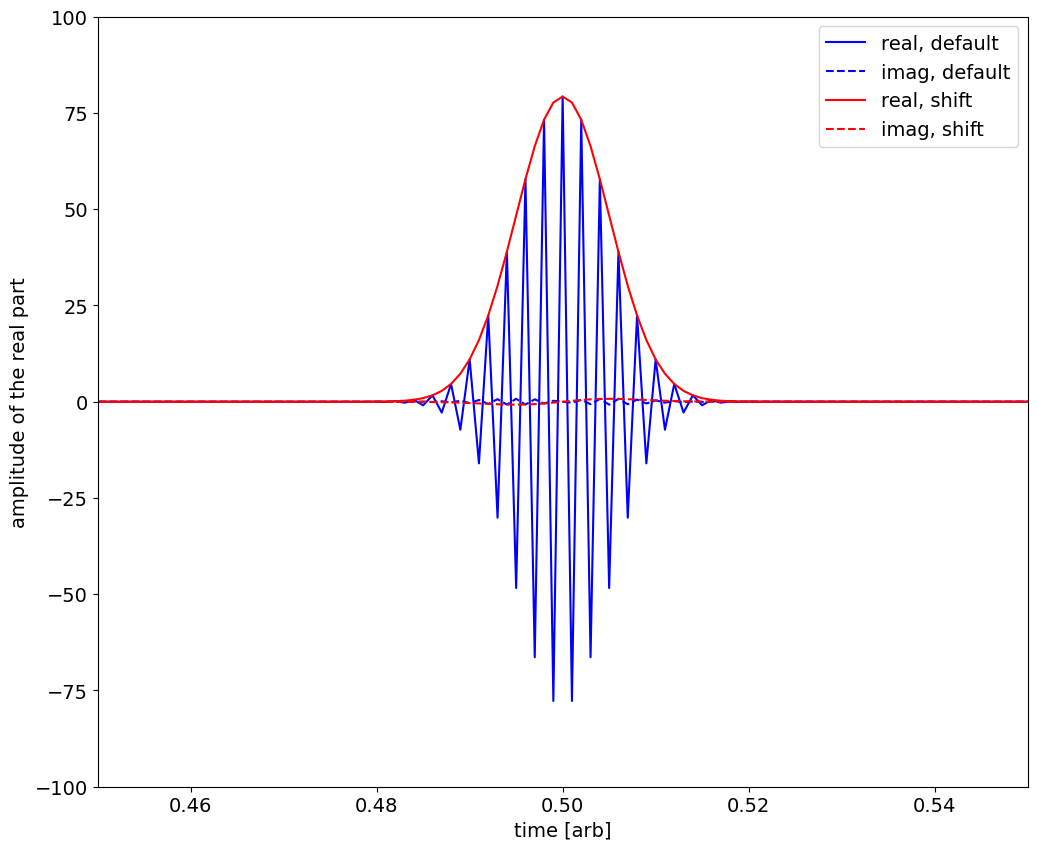

In [115]:
g = np.exp(-5 * ((t-np.mean(t))/.1)**2.)

## default centering
plt.plot(t,np.fft.fftshift(np.real(np.fft.fft(g))),"b", label='real, default')
plt.plot(t,np.fft.fftshift(np.imag(np.fft.fft(g))),"b--", label='imag, default')
## with a shift of the input
plt.plot(t,np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(g)))),"r",label='real, shift')
plt.plot(t,np.fft.fftshift(np.imag(np.fft.fft(np.fft.fftshift(g)))),"r--", label='imag, shift')
## labels etc
plt.xlabel("time [arb]")
plt.ylabel("amplitude of the real part")
plt.legend(loc='best')
#pl.title("FFT results for default centering (blue) and shifted(red). Real part is continuous, imaginary part is dashed")
plt.axis([0.45,.55,-100,100])

It is clear that both centerings give the same info, but the phase has been rotated to make the result purely real by shifting the input before the FFT.  If you see oscillaitons in your FFT results, this is almost always what is happening.

# Two dimensional FFTs

FFT2 implements the fourier transform in two dimensions. We will use the fft2 functionality of Numpy extensively in this course so here we build a few examples.   First we will generate a 2D gaussian and visualize its 2d fft.

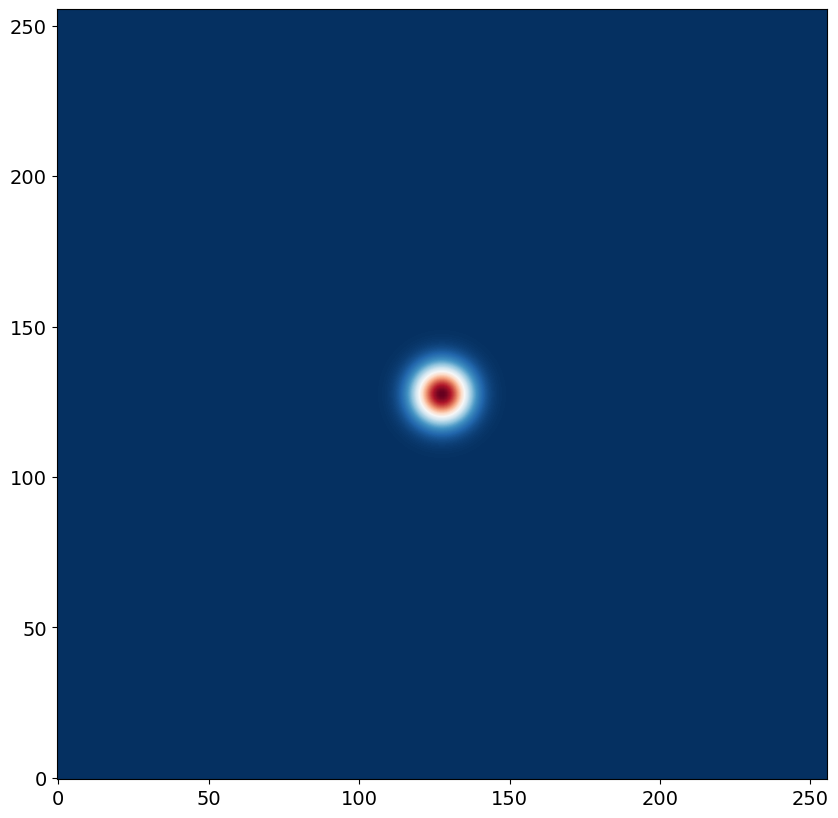

In [116]:
## first make a coordinate system
N = 256
x,y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N)) ## make a 2d array of x and y coordinates
r = np.sqrt(x**2 + y**2)  ## calculate the radial coordinate of each pixel

## now make a 2d gaussian
gaussian_2d = np.exp(-.5 *(r/.05)**2)

## now plot the gaussian
plt.imshow(gaussian_2d, interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)

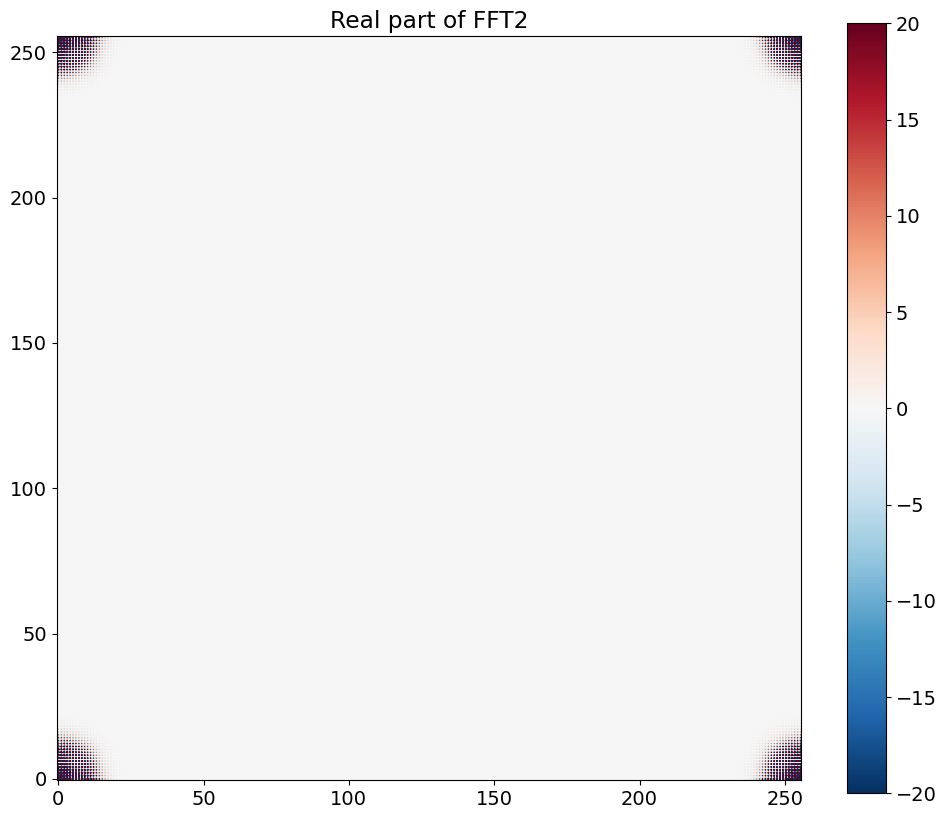

Text(0.5, 1.0, 'Imaginary part of FFT2')

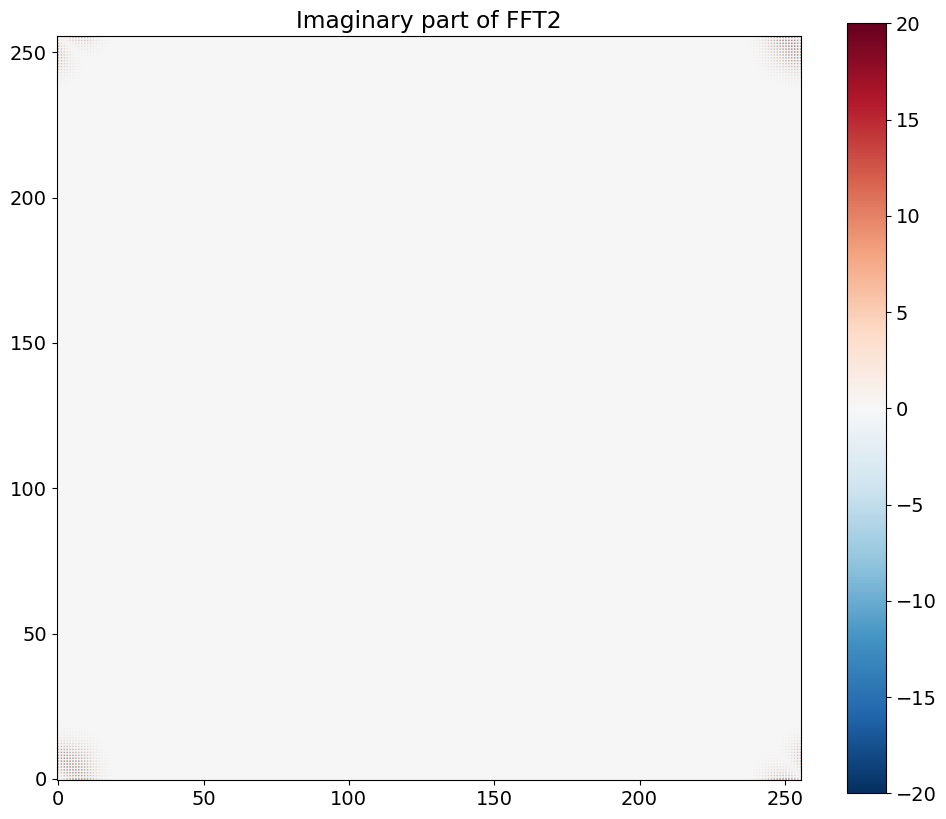

In [119]:
fft_ga_2d = np.fft.fft2(gaussian_2d)  ## calcualte the 2d FFT of our gaussian
im = plt.imshow(np.real(fft_ga_2d), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-20,20)
plt.colorbar()
plt.title('Real part of FFT2')
plt.show()
im = plt.imshow(np.imag(fft_ga_2d), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-20,20)
plt.colorbar()
plt.title('Imaginary part of FFT2')

From this example we see that

    (1) the FFT of a gaussian is a gaussian,
    (2) the FFT is a complex quantity,
    (2) the smaller the gaussian the bigger the FFT of it is (eg the uncertainty principle), and
    (3) the result is centered at zero frequency just as we would expect from the 1d example.
    
    
Depending on the application we must often carefully consider the centering of the input and output arrays.  Note above that the results oscillate on the pixel scale betwen positive and negative.  This is a results of the centering choices of the input array.  We must fix this with shfits just as we did in the 1D example.

Here we illustrate this with the following examples.  First we shift the input array using fftshift:

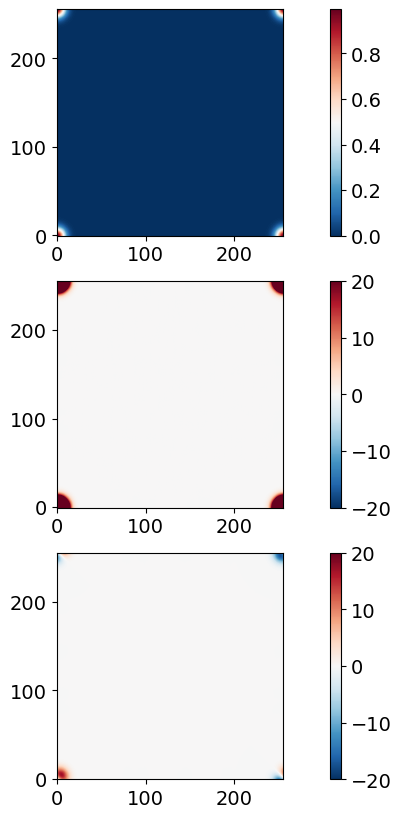

In [122]:
plt.subplot(3,1,1)
plt.imshow(np.fft.fftshift(gaussian_2d), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
plt.colorbar()


plt.subplot(3,1,2)
fft_ga_2d = np.fft.fft2(np.fft.fftshift(gaussian_2d))  ## calcualte the 2d FFT of our gaussian
im = plt.imshow(np.real(fft_ga_2d), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-20,20)
plt.colorbar()

plt.subplot(3,1,3)
im = plt.imshow(np.imag(fft_ga_2d), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-20,20)
plt.colorbar()



Note the FFT shift of the input array did not change the centering of the output array, but it did get rid of the oscillations.  We next also shift the output:

Text(0.5, 1.0, 'Imag part of shifted FFT')

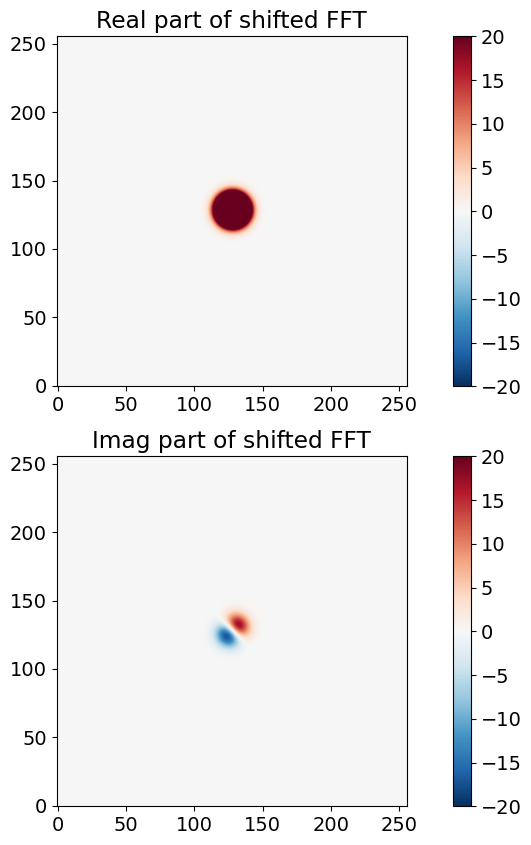

In [125]:
plt.subplot(2,1,1)

plt.imshow(np.fft.fftshift(gaussian_2d), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
fft_ga_2d = np.fft.fft2(np.fft.fftshift(gaussian_2d))  ## calcualte the 2d FFT of our gaussian
im = plt.imshow(np.fft.fftshift(np.real(fft_ga_2d)), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-20,20)
plt.colorbar()

plt.title('Real part of shifted FFT')

plt.subplot(2,1,2)
im = plt.imshow(np.fft.fftshift(np.imag(fft_ga_2d)), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-20,20)
plt.colorbar()
plt.title('Imag part of shifted FFT')



Depending on the appliation we will shift the input and output arrays to make sense of the results.

## 2D convolution

In the final example we present a 2d convolution, something that we use a lot in CMB analysis.

In [128]:
pwd

'/Users/ruhl/code/Tutorials/CMB_summer_school_JR'

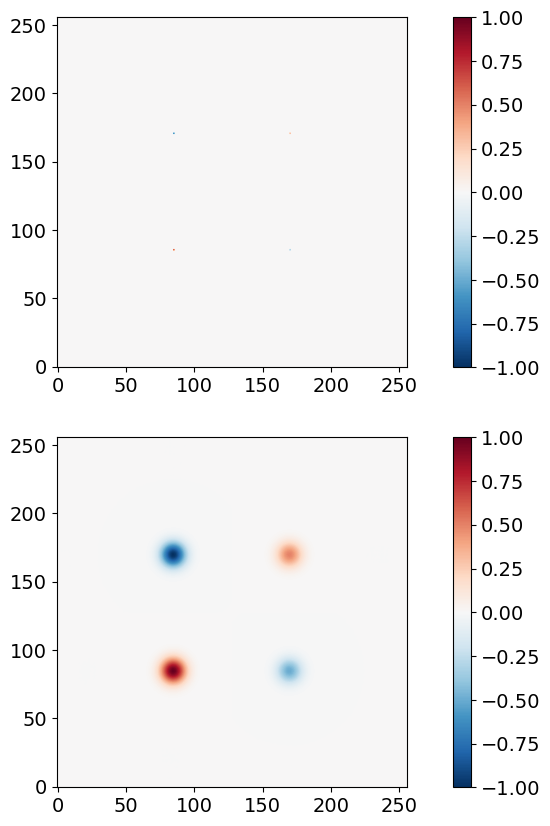

In [127]:
input = np.zeros([N,N])
input[int(N/3),int(N/3)] = 1
input[int(N*2/3),int(N*2/3)] = .5
input[int(N/3),int(N*2/3)] = -.5
input[int(N*2/3),int(N/3)] = -1

plt.subplot(2,1,1)
im = plt.imshow(input, interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-1.,1.)
plt.colorbar()

convolution = np.fft.ifft2(np.fft.fft2(np.fft.fftshift(gaussian_2d)) * np.fft.fft2(input))
plt.subplot(2,1,2)
im = plt.imshow(np.real(convolution), interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
im.set_clim(-1.,1.)
plt.colorbar()


For this applicaiton centering the kernel on zero frequency centers the peaks of the convolution on the peaks of the input map.  We will use this approach to generate realizations of point sources.